# Importing libraries


In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Load data


In [2]:
kickstarter_clean_df = pd.read_csv("./data/Part3.Team8.kickstarter_data_full_cleaned.csv", low_memory=False)


# Hypothesis 4: The currency of the project affects the success of the project


In [3]:
h4_df = kickstarter_clean_df[["currency", "SuccessfulBool"]]

In [4]:
h4_df

,currency,SuccessfulBool
0,USD,0
1,USD,0
2,USD,0
3,USD,0
4,EUR,0
...,...,...
20627,CHF,0
20628,EUR,0
20629,USD,0
20630,USD,0


# Convert currency into dummies


In [5]:
currency_dummies = pd.get_dummies(h4_df["currency"], prefix="currency", drop_first=True)

In [6]:
# conert to int
currency_dummies = currency_dummies.astype(int)

In [7]:
currency_dummies

,currency_CAD,currency_CHF,currency_DKK,currency_EUR,currency_GBP,currency_HKD,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
20627,0,1,0,0,0,0,0,0,0,0,0,0
20628,0,0,0,1,0,0,0,0,0,0,0,0
20629,0,0,0,0,0,0,0,0,0,0,0,1
20630,0,0,0,0,0,0,0,0,0,0,0,1


## Add the dummies to the h4_df and remove original column


In [8]:
h4_df = pd.concat([h4_df, currency_dummies], axis=1)

In [9]:
h4_df.drop(columns="currency", inplace=True)

In [10]:
h4_df.head()

,SuccessfulBool,currency_CAD,currency_CHF,currency_DKK,currency_EUR,currency_GBP,currency_HKD,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,1,0,0,0,0,0,0,0,0


# Feature importance


In [11]:
# xgboost for feature importance on a classification problem
import plotly.graph_objects as go
from xgboost import XGBClassifier

xgb_model = XGBClassifier()
xgb_model.fit(
    h4_df.drop(columns=["SuccessfulBool"]),
    h4_df["SuccessfulBool"],
)
feature_importance_df = pd.DataFrame(
    {
        "feature": h4_df.drop(columns=["SuccessfulBool"]).columns,
        "importance": xgb_model.feature_importances_,
    }
)
feature_importance_df.sort_values(by="importance", ascending=False, inplace=True)
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=feature_importance_df["feature"],
        y=feature_importance_df["importance"],
        marker_color="rgb(171, 226, 251)",
    )
)
fig.update_layout(
    title="Feature Importance",
    title_x=0.5,
    width=800,
    height=800,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
)
fig.show()


### We see that xgboost model show high importance for usd_pledged (coverted amount to USD) and currencies like GBP and EUR. USD have low impact on the model. We can drop all currencies except GBP and EUR and keep usd_pledged.


In [12]:
h4_df.drop(
    columns=[
        col
        for col in h4_df.columns
        if col
        not in [
            "SuccessfulBool",
            "usd_pledged",
            "currency_GBP",
            "currency_EUR",
            "currency_CAD",
        ]
    ],
    inplace=True,
)

# Split into X and y again


In [13]:
X = h4_df.drop(columns="SuccessfulBool")
y = h4_df["SuccessfulBool"]

# Split into train and test again


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


# Logistic Regression


In [15]:
from sklearn.linear_model import LogisticRegression

logistic_regression_model = LogisticRegression()


In [16]:
logistic_regression_model.fit(X_train, y_train)

LogisticRegression()

In [17]:
predictions_logistic_regression_train = logistic_regression_model.predict(X_train)
predictions_logistic_regression_test = logistic_regression_model.predict(X_test)

In [18]:
train_results_logistic_regression = pd.DataFrame(
    {"Actual": y_train, "Predicted": predictions_logistic_regression_train}
)
test_results_logistic_regression = pd.DataFrame(
    {"Actual": y_test, "Predicted": predictions_logistic_regression_test}
)


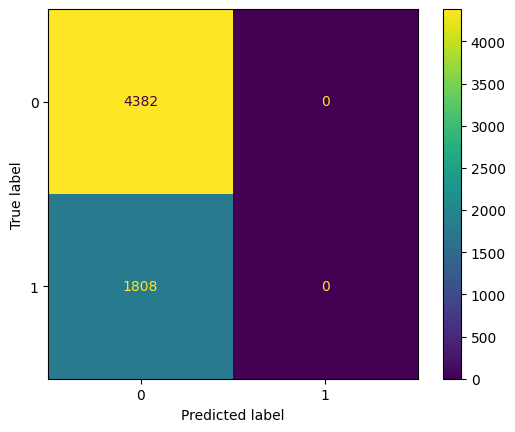

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, predictions_logistic_regression_test)
ConfusionMatrixDisplay(cm).plot()


In [20]:
from sklearn.metrics import classification_report

print("Logistic Regression Results (train):")
print(classification_report(y_train, predictions_logistic_regression_train))
print("Logistic Regression Results (test):")
print(classification_report(y_test, predictions_logistic_regression_test))


Logistic Regression Results (train):
              precision    recall  f1-score   support

           0       0.71      1.00      0.83     10232
           1       0.00      0.00      0.00      4210

    accuracy                           0.71     14442
   macro avg       0.35      0.50      0.41     14442
weighted avg       0.50      0.71      0.59     14442

Logistic Regression Results (test):
              precision    recall  f1-score   support

           0       0.71      1.00      0.83      4382
           1       0.00      0.00      0.00      1808

    accuracy                           0.71      6190
   macro avg       0.35      0.50      0.41      6190
weighted avg       0.50      0.71      0.59      6190



c:\Users\Avidan.DESKTOP-RGG0UVA\Desktop\Personal\final-project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Avidan.DESKTOP-RGG0UVA\Desktop\Personal\final-project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Avidan.DESKTOP-RGG0UVA\Desktop\Personal\final-project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Avidan.DESKTOP-RGG0UVA\Desktop\Personal\final-project\venv\Lib\site-packages

In [21]:
# ROC curve
from sklearn.metrics import roc_curve, roc_auc_score

predictions_proba = logistic_regression_model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, predictions_logistic_regression_test)
fpr, tpr, thresholds = roc_curve(y_test, predictions_proba[:, 1])


In [22]:
print("ROC AUC: %.3f" % roc_auc)

ROC AUC: 0.500


In [23]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=fpr,
        y=tpr,
        mode="lines",
        name="ROC curve (area = %0.2f)" % roc_auc,
        line=dict(color="darkorange", width=2),
        text=thresholds,
        hovertemplate="fpr: %{x:.2f}<br>tpr: %{y:.2f}<br>threshold: %{text:.2f}",
    )
)
fig.add_trace(
    go.Scatter(
        x=[0, 1],
        y=[0, 1],
        mode="lines",
        name="Random guess",
        line=dict(color="navy", width=2, dash="dash"),
    )
)
fig.update_layout(
    title="Receiver Operating Characteristic",
    xaxis_title="False Positive Rate",
    yaxis_title="True Positive Rate",
)
fig.show()

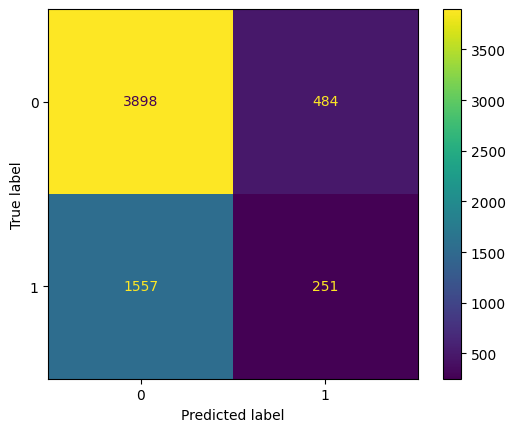

In [24]:
# logistic regression threshold 0.215
predictions_logistic_regression_test_threshold = [
    1 if x >= 0.3 else 0 for x in predictions_proba[:, 1]
]
cm = confusion_matrix(y_test, predictions_logistic_regression_test_threshold)
ConfusionMatrixDisplay(cm).plot()

In [25]:
print(classification_report(y_test, predictions_logistic_regression_test_threshold))

              precision    recall  f1-score   support

           0       0.71      0.89      0.79      4382
           1       0.34      0.14      0.20      1808

    accuracy                           0.67      6190
   macro avg       0.53      0.51      0.49      6190
weighted avg       0.61      0.67      0.62      6190



# KNN


In [26]:
# knn
from sklearn.neighbors import KNeighborsClassifier

In [27]:
knn = KNeighborsClassifier(n_neighbors=5)

In [28]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [29]:
predictions_knn_train = knn.predict(X_train)
predictions_knn_test = knn.predict(X_test)

In [30]:
train_results_knn = pd.DataFrame(
    {"Actual": y_train, "Predicted": predictions_knn_train}
)
test_results_knn = pd.DataFrame({"Actual": y_test, "Predicted": predictions_knn_test})


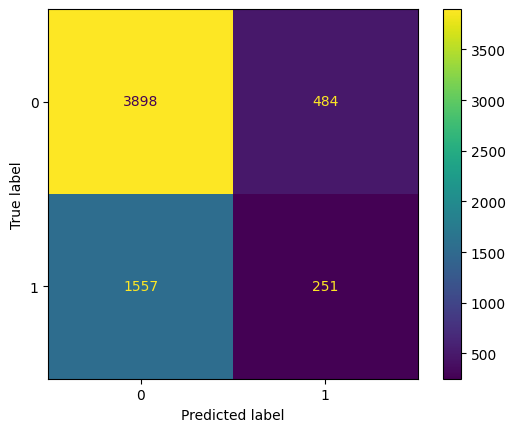

In [31]:
cm = confusion_matrix(y_test, predictions_knn_test)
ConfusionMatrixDisplay(cm).plot()

In [32]:
print("KNN Results (train):")
print(classification_report(y_train, predictions_knn_train))
print("KNN Results (test):")
print(classification_report(y_test, predictions_knn_test))

KNN Results (train):
              precision    recall  f1-score   support

           0       0.72      0.89      0.80     10232
           1       0.36      0.15      0.21      4210

    accuracy                           0.68     14442
   macro avg       0.54      0.52      0.51     14442
weighted avg       0.62      0.68      0.63     14442

KNN Results (test):
              precision    recall  f1-score   support

           0       0.71      0.89      0.79      4382
           1       0.34      0.14      0.20      1808

    accuracy                           0.67      6190
   macro avg       0.53      0.51      0.49      6190
weighted avg       0.61      0.67      0.62      6190



In [33]:
l = []
for i in range(1, 201, 2):
    knni = KNeighborsClassifier(n_neighbors=i)
    knni.fit(X_train, y_train)
    predictions_knni_test = knni.predict(X_test)
    l.append((i, knni.score(X_test, y_test)))

In [34]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=[i[0] for i in l],
        y=[i[1] for i in l],
        mode="lines+markers",
        marker_color="rgb(171, 226, 251)",
    )
)
fig.update_layout(
    title="Accuracy vs K",
    title_x=0.5,
    width=800,
    height=800,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
)
fig.show()

# Random forest


In [35]:
# random forest
from sklearn.ensemble import RandomForestClassifier

In [36]:
rnf_model = RandomForestClassifier(100, random_state=42, criterion="entropy")

In [37]:
rnf_model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=42)

In [38]:
predictions_rnf_train = rnf_model.predict(X_train)
predictions_rnf_test = rnf_model.predict(X_test)

In [39]:
train_results_rnf = pd.DataFrame(
    {"Actual": y_train, "Predicted": predictions_rnf_train}
)
test_results_rnf = pd.DataFrame({"Actual": y_test, "Predicted": predictions_rnf_test})


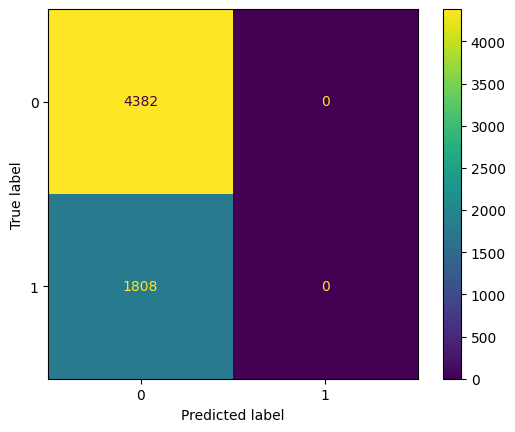

In [40]:
cm = confusion_matrix(y_test, predictions_rnf_test)
ConfusionMatrixDisplay(cm).plot()

In [41]:
print("Random Forest Results (train):")
print(classification_report(y_train, predictions_rnf_train))
print("Random Forest Results (test):")
print(classification_report(y_test, predictions_rnf_test))

Random Forest Results (train):
              precision    recall  f1-score   support

           0       0.71      1.00      0.83     10232
           1       0.00      0.00      0.00      4210

    accuracy                           0.71     14442
   macro avg       0.35      0.50      0.41     14442
weighted avg       0.50      0.71      0.59     14442

Random Forest Results (test):
              precision    recall  f1-score   support

           0       0.71      1.00      0.83      4382
           1       0.00      0.00      0.00      1808

    accuracy                           0.71      6190
   macro avg       0.35      0.50      0.41      6190
weighted avg       0.50      0.71      0.59      6190



c:\Users\Avidan.DESKTOP-RGG0UVA\Desktop\Personal\final-project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Avidan.DESKTOP-RGG0UVA\Desktop\Personal\final-project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Avidan.DESKTOP-RGG0UVA\Desktop\Personal\final-project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Avidan.DESKTOP-RGG0UVA\Desktop\Personal\final-project\venv\Lib\site-packages

In [42]:
l = []
for i in range(100, 1000, 100):
    print(i, end="\r")
    rfi = RandomForestClassifier(i, random_state=42, criterion="entropy")
    rfi.fit(X_train, y_train)
    predictions_i = rfi.predict(X_test)
    l.append((i, rfi.score(X_test, y_test)))

In [43]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=[i[0] for i in l],
        y=[i[1] for i in l],
        mode="lines+markers",
        marker_color="rgb(171, 226, 251)",
    )
)
fig.update_layout(
    title="Accuracy vs n_estimators",
    title_x=0.5,
    width=800,
    height=800,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
)
fig.show()


In [44]:
# run on two ranges with different step sizes
l = []
for i in range(100, 1000, 100):
    # for model with 100-1000 estimators each estimator run 10 times with different max_depth
    for j in range(1, 11):
        rfi = RandomForestClassifier(
            i, random_state=42, criterion="entropy", max_depth=j
        )
        rfi.fit(X_train, y_train)
        predictions_logistic_regression = rfi.predict(X_test)
        l.append((i, j, rfi.score(X_test, y_test)))

In [45]:
l.sort(key=lambda x: x[2], reverse=True)

In [46]:
l[0]

(100, 1, 0.7079159935379644)

In [48]:
# Tensorflow

import tensorflow as tf

# binary classification

# create model
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

# compile model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


# fit model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# evaluate model
model.evaluate(X_test, y_test, verbose=1)


# plot history
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=[i for i in range(1, 11)],
        y=history.history["accuracy"],
        mode="lines+markers",
        marker_color="rgb(171, 226, 251)",
    )
)
fig.update_layout(
    title="Accuracy vs Epochs",
    title_x=0.5,
    width=800,
    height=800,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
)
fig.show()

Epoch 1/10


452/452 [==============================] - 1s 1ms/step - loss: 0.6096 - accuracy: 0.7081
Epoch 2/10
452/452 [==============================] - 1s 1ms/step - loss: 0.5998 - accuracy: 0.7085
Epoch 3/10
452/452 [==============================] - 1s 1ms/step - loss: 0.5995 - accuracy: 0.7085
Epoch 4/10
452/452 [==============================] - 1s 1ms/step - loss: 0.5996 - accuracy: 0.7085
Epoch 5/10
452/452 [==============================] - 1s 1ms/step - loss: 0.5996 - accuracy: 0.7085
Epoch 6/10
452/452 [==============================] - 1s 1ms/step - loss: 0.5994 - accuracy: 0.7085
Epoch 7/10
452/452 [==============================] - 1s 1ms/step - loss: 0.5998 - accuracy: 0.7085
Epoch 8/10
452/452 [==============================] - 1s 1ms/step - loss: 0.5995 - accuracy: 0.7085
Epoch 9/10
452/452 [==============================] - 1s 1ms/step - loss: 0.5996 - accuracy: 0.7085
Epoch 10/10
194/194 [==============================] - 0s 1ms/step - loss: 0.5997 - accuracy: 0.7079
